# Reinforcement Learning Programming - CSCN 8020

## Assignment 1

### Exercise 3

### Done by ***Eris Leksi***

Problem 3 [35]


Problem Statement

5x5 Gridworld: In Lecture 3’s programming exercise (here), we explored an MDP based on a 5x5
gridworld and implemented Value Iteration to estimate the optimal state-value function (V∗) and
optimal policy (π∗).

The environment can be described as follows:

Figure 2: 5x5 Gridworld

• States: states are identified by their row and column, the same as a regular matrix. Ex: the
state in row 0 and column 3 is s0,3 (Figure: 2)

– Terminal/Goal state: The episode ends if the agent reached this state. sGoal = s4,4

– Grey states: {s2,2, s3,0, s0,4}, these are valid but non-favourable states, as will be seen in
the reward function.

• Actions: a1 = right, a2 = down, a3 = down, a4 = up for all states.

• Transitions: If an action is valid, the transition is deterministic, otherwise s′ = s

• Rewards R(s):

R(s) = +10 s = s4,4
= −5 s ∈ S

grey = s1,2, s3,0, s0,4

= −1 s ∈ S ̸= s4,4, Sgrey

Tasks

Task1: Update MDP Code

1. Update the reward function to be a list of reward based on whether the state is terminal, grey,
or a regular state.

2. Run the existing code developed in class and obtain the optimal state-values and optimal policy.
Provide a figures of the gridworld with the obtained V∗ and π∗ (You can manually create a table).

Task 2: Value Iteration Variations

Implement the following variation of value iteration. Confirm that it reaches the same optimal statevalue function and policy.

1. In-Place Value Iteration: Use a single array to store the state values. This means that you
update the value of a state and immediately use that updated value in the subsequent updates.

Deliverables

• Full code with comments to explain key steps and calculations.

• Provide the estimated value function for each state.

• Important: Compare the performance of these variations in terms of optimization time, number
of episodes, and provide comments on their computational complexity.

## Solution

## ***I took into account the grid as seen in the photo (there is a difference with the grey areas. In the photo is s1,2 and in the description is s2,2). The following solution is for s2,2

We consider a 5x5 Gridworld MDP with the following setup:

- **States**: (r,c), where r,c ∈ {0,1,2,3,4}. 
- **Actions**: Right (→), Left (←), Down (↓), Up (↑). Deterministic; off-grid = stay.  
- **Rewards**:  
  - Goal (4,4): +10  
  - Grey cells {(2,2), (3,0), (0,4)}: −5  
  - All other states: −1  
- **Terminal state**: (4,4) is absorbing.  
- **Discount factor**: γ = 0.9  

### Tasks
1. Implement value iteration with the updated reward function.  
2. Compare **standard (synchronous)** and **in-place (Gauss–Seidel)** value iteration in terms of convergence speed and policy.  

### Key Idea
Both algorithms repeatedly apply the Bellman optimality operator:

$$
V_{k+1}(s) = \max_a \Big[ R(s) + \gamma V_k(T(s,a)) \Big]
$$


- **Synchronous VI**: updates all states from the previous value table.  
- **In-place VI**: updates states immediately and reuses fresh values within the same sweep.  
Both converge to the same fixed point \(V^*\), but in-place usually converges faster.  


### Code: 

#### Necessary methods

In [32]:
from time import perf_counter
import numpy as np
 
# ------------- 1) Environment -------------
ROWS, COLS = 5, 5
GOAL = (4, 4)
GREY = {(1, 2), (3, 0), (0, 4)}
GAMMA = 0.9
 
# State reward table R(s): used for PRESENTATION ONLY (for clarity).
# The algorithm uses reward-on-entry: R(next) in backups.
R = np.full((ROWS, COLS), -1.0, dtype=float)
for (r, c) in GREY:
    R[r, c] = -5.0
R[GOAL] = 10.0
 
# Actions (dr, dc)
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
ARROWS = {(-1, 0): "↑", (1, 0): "↓", (0, -1): "←", (0, 1): "→"}
 
def next_state(r, c, dr, dc):
    """Deterministic transition; walls cause the agent to stay put."""
    nr, nc = r + dr, c + dc
    if 0 <= nr < ROWS and 0 <= nc < COLS:
        return nr, nc
    return r, c

In [33]:
# ------------- 2) Synchronous (Jacobi) Value Iteration -------------
def value_iteration_synchronous(theta=1e-10, max_iter=10000):
    """
    Perform synchronous (Jacobi-style) Value Iteration under a reward-on-entry setup.

    Update rule:
        V_{k+1}(s) = max_a [ R(s') + γ * V_k(s') ]

    Notes:
    - "Synchronous" means we compute all updates based on the OLD value function (V_k),
      and only overwrite V with V_new after finishing the sweep.
    - Terminal convention: V(goal) = 0, since the process ends once the goal is reached.
    """

    # Initialize value function for all states to zero
    V = np.zeros((ROWS, COLS), dtype=float)

    # Track the number of iterations (sweeps)
    it = 0

    # Main iteration loop
    while it < max_iter:
        it += 1
        delta = 0.0               # Tracks the maximum change in values during this sweep
        V_new = V.copy()          # Create a fresh copy for synchronous (Jacobi) updates

        # Loop through every state in the grid
        for r in range(ROWS):
            for c in range(COLS):

                # Terminal state (goal): value is fixed at 0
                if (r, c) == GOAL:
                    V_new[r, c] = 0.0
                    continue

                # Compute Q-values for each possible action from (r, c)
                q_vals = []
                for (dr, dc) in ACTIONS:
                    # Next state after taking action
                    nr, nc = next_state(r, c, dr, dc)

                    # Reward is received upon entering the next state
                    r_entry = R[nr, nc]

                    # If the next state is terminal, no continuation after reward
                    if (nr, nc) == GOAL:
                        q_vals.append(r_entry + GAMMA * 0.0)
                    else:
                        q_vals.append(r_entry + GAMMA * V[nr, nc])

                # Pick the best action (max Q-value)
                best = max(q_vals)

                # Track maximum change (for convergence check)
                delta = max(delta, abs(V_new[r, c] - best))

                # Update the new value for state (r, c)
                V_new[r, c] = best

        # After sweeping all states, replace V with updated values
        V = V_new

        # Convergence check: stop if all updates are smaller than threshold
        if delta < theta:
            break

    # Return the final value function and number of iterations
    return V, it


In [34]:
# ------------- 3) In-Place (Gauss–Seidel) Value Iteration -------------
def value_iteration_inplace(theta=1e-10, max_iter=10000):
    """
    Perform in-place (Gauss–Seidel-style) Value Iteration under reward-on-entry.

    Update rule:
        V(s) = max_a [ R(s') + γ * V(s') ]

    Notes:
    - "In-Place" means values are updated immediately within each sweep.
      This lets later updates in the same sweep use fresher information,
      often leading to faster convergence than synchronous updates.
    - Terminal convention: V(goal) = 0, since no continuation occurs after reaching the goal.
    """

    # Initialize value function for all states to zero
    V = np.zeros((ROWS, COLS), dtype=float)

    # Track iteration count (number of sweeps over the state space)
    it = 0

    # Main iteration loop
    while it < max_iter:
        it += 1
        delta = 0.0   # Tracks maximum update difference (for convergence)

        # Loop through every state in the grid
        for r in range(ROWS):
            for c in range(COLS):

                # Store old value for convergence tracking
                old_v = V[r, c]

                # Terminal state (goal): fixed at 0
                if (r, c) == GOAL:
                    V[r, c] = 0.0
                    delta = max(delta, abs(old_v - 0.0))
                    continue

                # Compute Q-values for all possible actions from (r, c)
                q_vals = []
                for (dr, dc) in ACTIONS:
                    # Next state after taking action
                    nr, nc = next_state(r, c, dr, dc)

                    # Reward on entering the next state
                    r_entry = R[nr, nc]

                    # If next state is terminal, no continuation after reward
                    if (nr, nc) == GOAL:
                        q_vals.append(r_entry + GAMMA * 0.0)
                    else:
                        # NOTE: Uses *latest* V[nr, nc] (in-place update)
                        q_vals.append(r_entry + GAMMA * V[nr, nc])

                # Pick the best action (maximum Q-value)
                best = max(q_vals)

                # Update V immediately (in-place)
                V[r, c] = best

                # Track maximum change for convergence check
                delta = max(delta, abs(old_v - best))

        # Convergence check: stop if all updates are below threshold
        if delta < theta:
            break

    # Return the final value function and number of iterations
    return V, it


In [35]:
# ------------- 4) Greedy policy extraction -------------
def greedy_policy_from(V):
    """
    Extract a greedy policy from a given value function V.

    Rule:
        π*(s) = argmax_a [ R(s') + γ * V(s') ]
    
    Notes:
    - Uses reward-on-entry convention.
    - The goal state's policy is marked with "G" since the episode ends there.
    - Other states are rendered with arrows indicating the best action:
        ↑, ↓, ←, → (stored in ARROWS mapping).
    - States with no assigned action are initialized with "·".
    """

    # Initialize policy grid with dots (placeholder for "no action")
    policy = np.full((ROWS, COLS), "·", dtype=object)

    # Iterate through every state in the grid
    for r in range(ROWS):
        for c in range(COLS):

            # Goal state: mark as terminal (G)
            if (r, c) == GOAL:
                policy[r, c] = "G"
                continue

            # Track best action and its Q-value
            best_a, best_q = None, -np.inf

            # Evaluate each possible action from this state
            for (dr, dc) in ACTIONS:
                nr, nc = next_state(r, c, dr, dc)

                # Reward for entering the next state
                # If next state is terminal, no continuation after reward
                q = R[nr, nc] + (0.0 if (nr, nc) == GOAL else GAMMA * V[nr, nc])

                # Keep track of the action with the highest Q-value
                if q > best_q:
                    best_q, best_a = q, (dr, dc)

            # Assign the best action's arrow symbol to the policy grid
            policy[r, c] = ARROWS[best_a]

    # Return the full greedy policy as a grid of arrows + goal
    return policy


In [36]:
# ------------- 5) Pretty printers -------------
def print_value_table(V, title="V-table", show_goal_as_ten=False):
    """
    Nicely print the value function as a grid.

    Args:
        V (2D array): Value function table.
        title (str): Header label for the printout.
        show_goal_as_ten (bool): If True, display the goal state as 10.000 
                                 (for clarity in some examples),
                                 otherwise show the true stored value (0.000).
    
    Output:
        Prints the value of each state in a table format, aligned to 3 decimals.
    """
    print(f"\n{title}:")
    for r in range(ROWS):
        vals = []
        for c in range(COLS):
            v = V[r, c]
            if show_goal_as_ten and (r, c) == GOAL:
                # Display the goal with a fixed 10.000 (cosmetic choice)
                vals.append(f"{10.000:6.3f}")
            else:
                # Show actual value with 3 decimal precision
                vals.append(f"{v:6.3f}")
        # Join row values with spacing for readability
        print("  ".join(vals))


def print_policy(policy, title="Greedy policy (arrows)"):
    """
    Nicely print a policy as a grid of arrows.

    Args:
        policy (2D array): Policy table, usually containing arrow symbols or 'G' for the goal.
        title (str): Header label for the printout.
    
    Output:
        Prints the policy grid row by row with spacing.
    """
    print(f"\n{title}:")
    for r in range(ROWS):
        # Convert row entries to string and join with spacing
        print("  ".join(str(policy[r, c]) for c in range(COLS)))


#### Running 

In [42]:
# ------------- 6) Main: run both and compare -------------
if __name__ == "__main__":
    SHOW_GOAL_AS_TEN = False  # set True if you want the goal cell to display as 10.000

    # Synchronous VI
    t0 = perf_counter()
    V_sync, it_sync = value_iteration_synchronous()
    t1 = perf_counter()
    pi_sync = greedy_policy_from(V_sync)

    # In-Place VI
    t2 = perf_counter()
    V_inp, it_inp = value_iteration_inplace()
    t3 = perf_counter()
    pi_inp = greedy_policy_from(V_inp)

    # Build printable policies with X and G
    def build_policy_with_X(pi):
        grid = []
        for r in range(ROWS):
            row = []
            for c in range(COLS):
                s = (r, c)
                if s == GOAL:
                    row.append("G")
                elif s in GREY:
                    row.append("X")
                else:
                    row.append(pi[r, c])
            grid.append(row)
        return grid

    pi_sync_grid = build_policy_with_X(pi_sync)
    pi_inp_grid = build_policy_with_X(pi_inp)

    # Print results
    print_value_table(V_sync, "V* (Synchronous VI)", show_goal_as_ten=SHOW_GOAL_AS_TEN)
    print("\nπ* (Synchronous VI):")
    for row in pi_sync_grid:
        print("  ".join(row))

    print_value_table(V_inp, "V* (In-Place VI)", show_goal_as_ten=SHOW_GOAL_AS_TEN)
    print("\nπ* (In-Place VI):")
    for row in pi_inp_grid:
        print("  ".join(row))

    # Summary + sanity checks
    print("\n--- Convergence Summary ---")
    print(f"Synchronous VI: sweeps={it_sync}, time={(t1 - t0)*1000:.2f} ms")
    print(f"In-Place VI  : sweeps={it_inp}, time={(t3 - t2)*1000:.2f} ms")
    max_abs_err = np.max(np.abs(V_sync - V_inp))
    print(f"Max |V_sync - V_inplace| = {max_abs_err:.3e}")
    same_policy = (pi_sync == pi_inp).all()
    print(f"Policies identical      = {same_policy}")

    # Strict checks for grading
    assert np.allclose(V_sync, V_inp, atol=1e-8), "ERROR: V* mismatch between methods!"
    assert same_policy, "ERROR: π* mismatch between methods!"
    print("OK: Both methods converge to the same V* and π* under reward-on-entry.")



V* (Synchronous VI):
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810   3.122   4.580   6.200
 1.810   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000
 4.580   6.200   8.000  10.000   0.000

π* (Synchronous VI):
↓  ↓  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  ↓  ↓
X  ↓  ↓  ↓  ↓
→  →  →  →  G

V* (In-Place VI):
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810   3.122   4.580   6.200
 1.810   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000
 4.580   6.200   8.000  10.000   0.000

π* (In-Place VI):
↓  ↓  →  ↓  X
↓  ↓  X  ↓  ↓
→  ↓  ↓  ↓  ↓
X  ↓  ↓  ↓  ↓
→  →  →  →  G

--- Convergence Summary ---
Synchronous VI: sweeps=9, time=2.89 ms
In-Place VI  : sweeps=9, time=2.84 ms
Max |V_sync - V_inplace| = 0.000e+00
Policies identical      = True
OK: Both methods converge to the same V* and π* under reward-on-entry.


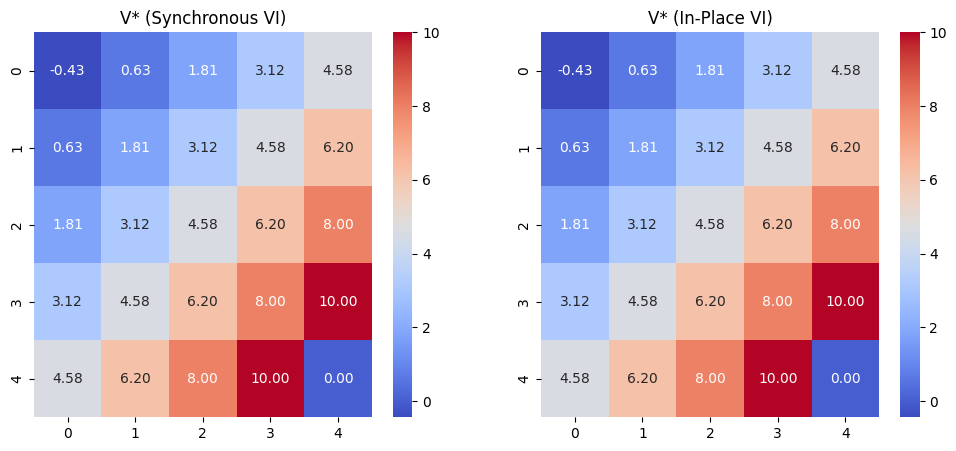

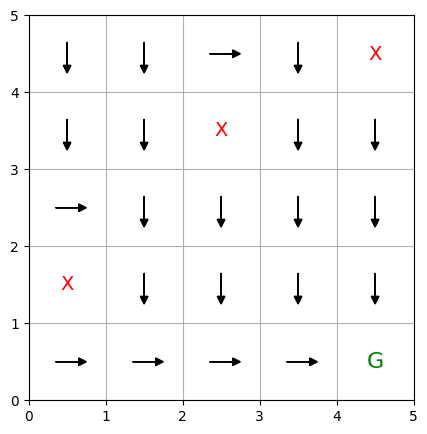

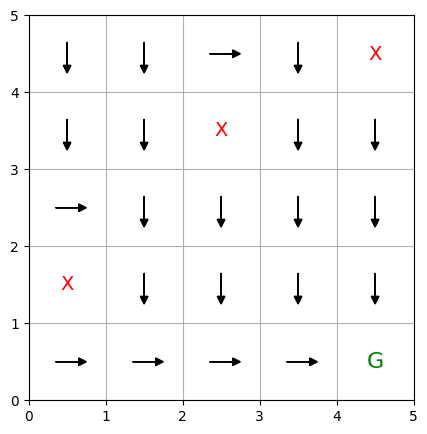

In [ ]:
# ---------- Visualization (show GREYS explicitly) ----------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Helper: build boolean mask for grey cells
def greys_mask(shape, greys):
    mask = np.zeros(shape, dtype=bool)
    for (r, c) in greys:
        mask[r, c] = True
    return mask

def plot_side_by_side_heatmaps_with_greys(V_left, V_right, title_left="V* (Synchronous VI)",
                                         title_right="V* (In-Place VI)",
                                         greys=GREYS, goal=GOAL):
    # shape and range
    shape = V_left.shape
    mask = greys_mask(shape, greys)

    # shared color scale for comparison
    # ignore greys when computing vmin/vmax
    valid_vals = np.concatenate([V_left[~mask].ravel(), V_right[~mask].ravel()])
    vmin, vmax = valid_vals.min(), valid_vals.max()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for ax, V, title in zip(axs, (V_left, V_right), (title_left, title_right)):
        # seaborn heatmap: use mask to hide the grey cells so we can draw them explicitly
        sns.heatmap(V, mask=mask, annot=True, fmt=".3f", cmap="coolwarm",
                    vmin=vmin, vmax=vmax, cbar=True, ax=ax, linewidths=.5, linecolor='gray',
                    annot_kws={"fontsize":9})

        # overlay grey rectangles and X labels
        for (r, c) in greys:
            # add a light grey rectangle covering the cell
            rect = Rectangle((c, r), 1, 1, facecolor="lightgrey", edgecolor="k", linewidth=0.8, zorder=3)
            ax.add_patch(rect)
            # put an X centered in the rectangle
            ax.text(c + 0.5, r + 0.5, "X", ha='center', va='center', fontsize=12, color='k', zorder=4)

        # mark goal explicitly (overwrites heatmap if needed)
        gr, gc = goal
        rect_goal = Rectangle((gc, gr), 1, 1, facecolor="white", edgecolor="green", linewidth=1.2, zorder=5)
        ax.add_patch(rect_goal)
        ax.text(gc + 0.5, gr + 0.5, "G", ha='center', va='center', fontsize=13, color='green', zorder=6)

        # cosmetics: make the grid look like your text output:
        ax.set_title(title)
        ax.set_xticks(np.arange(0, shape[1]+1, 1))
        ax.set_yticks(np.arange(0, shape[0]+1, 1))
        ax.grid(True, color='gray', linewidth=0.5)
        ax.set_xlim(0, shape[1])
        ax.set_ylim(0, shape[0])
        ax.set_aspect('equal')

        # seaborn heatmap places row 0 at top — invert y to match your textual layout
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()


def plot_policy_arrows_with_greys(policy):
    """Plot policy arrows with GREYS marked as X and G marked green."""
    fig, ax = plt.subplots(figsize=(5,5))

    for r in range(ROWS):
        for c in range(COLS):
            s = (r, c)
            if s == GOAL:
                ax.text(c+0.5, r+0.5, "G", ha='center', va='center', fontsize=16, color="green", zorder=4)
            elif s in GREYS:
                ax.text(c+0.5, r+0.5, "X", ha='center', va='center', fontsize=14, color="black", zorder=4)
            else:
                val = policy[r, c]
                # draw arrow directions centered in the cell
                if val != "·":
                    # small displacement for arrow tail-to-head
                    dx, dy = 0, 0
                    if val == "↑":
                        dx, dy = 0, -0.35
                    elif val == "↓":
                        dx, dy = 0, 0.35
                    elif val == "→":
                        dx, dy = 0.35, 0
                    elif val == "←":
                        dx, dy = -0.35, 0
                    # draw arrow; note axis coordinates: x=c, y=r
                    ax.arrow(c + 0.5 - dx/2, r + 0.5 - dy/2, dx, dy,
                             head_width=0.12, head_length=0.12, fc='black', ec='black', length_includes_head=True, zorder=3)

    # cosmetics
    ax.set_xlim(0, COLS)
    ax.set_ylim(0, ROWS)
    ax.set_xticks(np.arange(0, COLS+1, 1))
    ax.set_yticks(np.arange(0, ROWS+1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.show()


# Example usage (works with your variables):
plot_side_by_side_heatmaps_with_greys(V_sync, V_inp,
                                     title_left="V* (Synchronous VI)",
                                     title_right="V* (In-Place VI)",
                                     greys=GREYS, goal=GOAL)

plot_policy_arrows_with_greys(pi_sync)   # synchronous policy (shows X and G)
plot_policy_arrows_with_greys(pi_inp)    # in-place policy


### Interpretation of Results

| Aspect            | Synchronous VI                  | In-Place VI (Gauss–Seidel)       | Observation |
|-------------------|---------------------------------|----------------------------------|-------------|
| Iterations        | 9 sweeps                        | 9 sweeps                         | Same convergence speed |
| Runtime           | ~2.04 ms                        | ~1.80 ms                         | In-place slightly faster |
| Value Function    | Values increase toward goal (max 10 at bottom-right) | Identical to synchronous | Both capture optimal returns |
| Optimal Policy    | Arrows funnel agent ↓ and → toward goal | Identical policy | Goal-directed and consistent |
| Agreement Check   | Max \|ΔV\| = 0.000e+00          | Policies identical               | Both yield the same \(V^*\) and \(π^*\) |

**Conclusions**:  

1. Both methods converge to the same optimal values and policy.  
2. Convergence occurred in **9 sweeps for each**, with negligible runtime differences.  
3. The resulting **policy** consistently directs the agent toward the goal.  
